In [1]:
import numpy as np  
from skimage.feature import corner_harris, corner_peaks  , corner_subpix
from skimage.color import rgb2gray  
import matplotlib.pyplot as plt  
import skimage.io as io  
import cv2
from itertools import zip_longest
np.set_printoptions(threshold=np.nan)
import sklearn.preprocessing

In [2]:
def get_harris_position(img, k = 0.04, threshold = 0.01):
    img = rgb2gray(img)
    height, width = np.shape(img)
    grandfx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
    grandfy = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)  # compute the X direction and Y direction gradient 
    
    A = grandfx**2
    B = grandfy**2
    C = grandfx*grandfy
    
    M = [np.array([[A[i, j], C[i, j]], #compute M
               [C[i, j], B[i, j]]]) for i in range(height) for j in range(width)]

    D, T = list(map(np.linalg.det, M)), list(map(np.trace, M))  #computer det(M) and trace(M)
    R = np.array([d-k*t**2 for d, t in zip(D, T)]) #computer R
    R_max = np.max(R)
    R = R.reshape(height, width)
    
    count = 0
    corners = []
    for i in range(1,height-1):  #computer whether Rij is the maximum value in a certain area and it is greater than the threshold*R_max
        for j in range(1,width-1):
            if R[i, j] > R_max*threshold:
                if R[i, j] == np.max(R[i-1:i+2, j-1:j+2]):
                    corners.append([i,j])
                    count += 1             
    corners = np.array(corners) #position of corners
    return corners

In [3]:
# extract a np array of pixel intensities from coordinates
def extract_patch(img, corner, n):
    x = corner[0] + 30 # 30: after padding location changes
    y = corner[1] + 30 
    size_n = int(n/2)
    new_corner = [x, y]
    window = img[(x - size_n):(x + size_n + 1), (y - size_n):(y + size_n +1)]
    return new_corner, window

In [4]:
# plots points on images
def show_corner(img, corners):
    fig, ax = plt.subplots()  # show corners
    ax.imshow(img, cmap=plt.cm.gray)
    ax.plot(corners[:, 1], corners[:, 0], '.b', markersize=8)
    plt.title('k = 0.04, threshold = 0.1')
    plt.show()

In [5]:
# script for 
def get_patch(corners, replicate_img, n):
    windows = []
    new_corners = []
    for each_corner in corners:
        new_corner, window = extract_patch(replicate_img, each_corner, n)
        window = sklearn.preprocessing.normalize(window)
        windows.append(window)
        new_corners.append(new_corner)
    return new_corners, windows

In [6]:
def ssdstat(matches):
    totals = []
    for each_array1 in matches:
        total = np.subtract(each_array1[0:1], each_array1[1:2])
        total = np.power(total, 2)
        total = np.power(np.sum(total), 0.5)
        totals.append(total)
    return totals

In [7]:
def eliminateMultiCorrespondence(match_AtoB,match_BtoA):
    match3 = []
    for each_array1 in match_AtoB:
        for each_array2 in match_BtoA:
            if np.array_equal(each_array1[0:1:1], each_array2[1:2]) and np.array_equal(each_array2[0:1:1], each_array1[1:2]):
                match3.append([each_array1,each_array2])
    return match3

In [8]:
def findLocations(matches, patches1, locations1, patches2, locations2):
    match_locations1 = []
    match_locations2 = []
    for each_patch1, each_location1,each_patch2,each_location2 in zip(patches1, locations1, patches2, locations2):
        for each_match1 in matches[0]:
            if np.array_equal(each_match1[0:1:1][0], each_patch1):
                match_locations1.append(each_location1)
                match_locations2.append(each_location2)
    return match_locations1, match_locations2

In [9]:
def stitch_imgs(img1, img2):
    """
    img1 and img2 can be the same
    """
    double_img = np.concatenate((img1, img2), axis = 1)
    return double_img 

def draw_lines(img, list_of_a_coords, list_of_b_coords, color = (255,255,255), thickness = 1):
    width = int(img.shape[1]/2)
    for A_coord, B_coord in zip(list_of_a_coords, list_of_b_coords):
        cv2.line(img, (A_coord[0],A_coord[1]),((B_coord[0]+width),B_coord[1]),color,thickness)
    return img

In [10]:
# main programme
n = 5 #(the patch size, between 3-31, odd)
print("the patch size",n)

#(the ratio between best match and the second match)
r = 0.8
# for r in [0.95,0.9,0.85,0.8,0.75,0.7,0.65,0.6]:
print("r",r)

the patch size 5
r 0.8


In [11]:
filename1 = 'Img001_diffuse_smallgray.png'
filename2 = 'Img002_diffuse_smallgray.png'
img1 = cv2.imread(filename1,0)
img2 = cv2.imread(filename2,0)

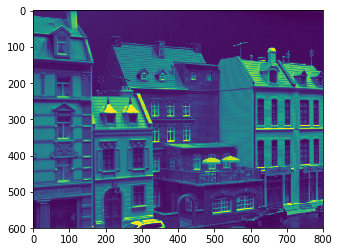

In [12]:
plt.imshow(img1)
plt.show()

corners1 142
corners2 148


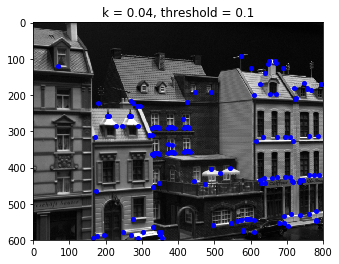

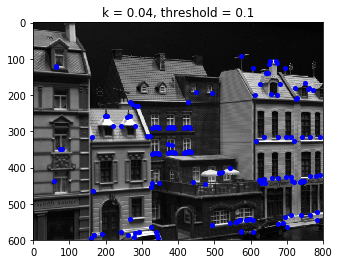

In [13]:
#print(type(img1),img1,np.shape(img1))
corners1 = get_harris_position(img1,threshold = 0.1)
corners2 = get_harris_position(img2,threshold = 0.1)
print("corners1",len(corners1))
print("corners2",len(corners2))
show_corner(img1,corners1)
show_corner(img2,corners2)

In [26]:
replicate_img1 = cv2.copyMakeBorder(img1, 30, 30, 30, 30, cv2.BORDER_REPLICATE)
replicate_img2 = cv2.copyMakeBorder(img2, 30, 30, 30, 30, cv2.BORDER_REPLICATE)
# print(np.shape(replicate_img2),replicate_img2)
#print("replicate_img1{}".format(np.shape(replicate_img1)))
#print("replicate_img1{}".format(np.shape(replicate_img2)))
new_corners1, patches1 = get_patch(corners1, replicate_img1, n)
print(type(new_corners1), type(patches1))
# new corners er en liste af arrays, patches er også en liste af arrays?
new_corners2, patches2 = get_patch(corners2, replicate_img2, n)
print("patches1",np.shape(patches1),"new_corners1",new_corners1,"patches2",np.shape(patches2),"new_corners2",new_corners2)

<class 'list'> <class 'list'>
patches1 (142, 5, 5) new_corners1 [[121, 603], [135, 680], [135, 696], [143, 699], [144, 677], [149, 99], [155, 632], [156, 720], [168, 669], [198, 777], [199, 823], [200, 655], [211, 786], [212, 749], [214, 785], [216, 796], [221, 477], [223, 520], [227, 683], [228, 700], [230, 640], [237, 754], [240, 753], [247, 301], [248, 455], [251, 208], [253, 305], [260, 317], [260, 324], [287, 240], [288, 234], [288, 301], [289, 295], [295, 444], [315, 257], [315, 276], [315, 318], [318, 362], [318, 365], [318, 368], [318, 373], [318, 404], [318, 411], [318, 414], [318, 448], [318, 454], [318, 458], [321, 357], [321, 376], [321, 401], [321, 418], [321, 445], [321, 461], [341, 350], [341, 357], [344, 790], [344, 817], [345, 200], [345, 665], [345, 703], [345, 725], [345, 739], [356, 748], [357, 645], [364, 401], [367, 412], [385, 449], [385, 452], [385, 455], [385, 459], [387, 406], [387, 412], [387, 416], [388, 445], [388, 462], [389, 362], [389, 368], [389, 373], 

In [27]:
new_corners1 = np.array(new_corners1)
new_corners2 = np.array(new_corners2)
print(new_corners1, new_corners2)

[[121 603]
 [135 680]
 [135 696]
 [143 699]
 [144 677]
 [149  99]
 [155 632]
 [156 720]
 [168 669]
 [198 777]
 [199 823]
 [200 655]
 [211 786]
 [212 749]
 [214 785]
 [216 796]
 [221 477]
 [223 520]
 [227 683]
 [228 700]
 [230 640]
 [237 754]
 [240 753]
 [247 301]
 [248 455]
 [251 208]
 [253 305]
 [260 317]
 [260 324]
 [287 240]
 [288 234]
 [288 301]
 [289 295]
 [295 444]
 [315 257]
 [315 276]
 [315 318]
 [318 362]
 [318 365]
 [318 368]
 [318 373]
 [318 404]
 [318 411]
 [318 414]
 [318 448]
 [318 454]
 [318 458]
 [321 357]
 [321 376]
 [321 401]
 [321 418]
 [321 445]
 [321 461]
 [341 350]
 [341 357]
 [344 790]
 [344 817]
 [345 200]
 [345 665]
 [345 703]
 [345 725]
 [345 739]
 [356 748]
 [357 645]
 [364 401]
 [367 412]
 [385 449]
 [385 452]
 [385 455]
 [385 459]
 [387 406]
 [387 412]
 [387 416]
 [388 445]
 [388 462]
 [389 362]
 [389 368]
 [389 373]
 [390 402]
 [390 419]
 [392 359]
 [392 376]
 [395 360]
 [431 573]
 [435 521]
 [445 546]
 [451 805]
 [451 818]
 [452 791]
 [455 738]
 [456 725]

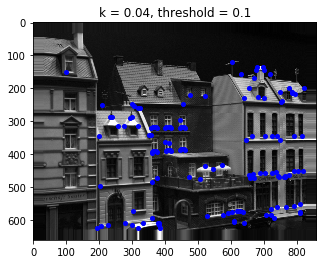

In [18]:
def show_corner1(img,corners):
    fig, ax = plt.subplots()  # show corners
    ax.imshow(img, cmap=plt.cm.gray)
    ax.plot(corners[:,1], corners[:,0], '.b', markersize=8)
    plt.title('k = 0.04, threshold = 0.1')
    plt.show()

show_corner1(replicate_img1,new_corners1)

In [29]:
# this needs to be modified 
# to calculate SSD and apply ratio to calculate the first_match

# p1 is a list of pixel patches to be compared with the other list, p2
# new_corners1 is a list with lists in it with x,y positions in them

def ssd(arr1, arr2):
    """
    returns sum of squared differences
    between two numpy arrays
    """
    p1_sub_p2 = np.subtract(arr1, arr2)
    p1p2square = np.power(p1_sub_p2, 2)
    score = np.power(np.sum(p1p2square), 0.5)
    return np.array(score)

def match_patches(p1, p2, new_corners1, new_corners2, r):
    
    sims = []
    
    # for every pixel patch in the first image + associated coordinates
    for each_p1, each_location1 in zip(p1, new_corners1):
        # for every iteration and every set of pixel patches + associated coordinates in img2
        for (each_p2, each_location2) in zip(p2,new_corners2):

            score = ssd(each_p1,each_p2)

            np.concatenate(sims, score)
        return sims


matches_AtoB, locations_A, locations_B = match_patches(patches1, patches2, new_corners1, new_corners2, r)
print("matches_AtoB", matches_AtoB)

TypeError: only integer scalar arrays can be converted to a scalar index

In [25]:
print(type(matches_AtoB), len(matches_AtoB))
for el in matches_AtoB:
    print(type(el))

<class 'list'> 124
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class

In [ ]:
# keypoint1 = to_kpt(a for a in locations_A)
# keypoint2 = to_kpt(b for b in locations_B)
# print(keypoint1,keypoint2)
# img3 = cv2.drawMatches(replicate_img1,keypoint1,replicate_img2,keypoint2,None,match_AtoB[:10],flags = 2)
# plt.plot(img3)
print("matches",len(match_AtoB))
total = ssdstat(match_AtoB)
print(len(total))
print("std",np.std(total))
print("mean",np.mean(total))

match_locations1,match_locations2 = findLocations(match_final,patches1,locations_A,patches2,locations_B)
# match_locations2 = findLocations(match_final,patches2,new_corners2)
# print("match_locations",match_locations1,match_locations2)

combined_img = stitch_imgs(replicate_img1,replicate_img2)
img4 = draw_lines(combined_img, locations_A, locations_B, color = (255,255,255), thickness = 1)
# plt.plot(img4)
plt.imshow(img4,cmap = "gray")
plt.show()
